In [145]:
from pathlib import Path

import awkward as ak
import pandas as pd
import uproot
import numpy as np
import matplotlib.pyplot as plt

import matplotlib
matplotlib.rcParams.update({'font.size': 14})

from scipy.stats import norm, skew

In [146]:
def summary_to_df(rootobj, keys):
    return ak.to_dataframe(rootobj.arrays(keys), how='outer').reset_index().drop(columns=["entry","subentry"])

In [147]:
inputDir = Path("../output_odd_g4_n20_4GeV")

summary_gsf_root = uproot.open(str(inputDir / "root/tracksummary_gsf.root:tracksummary"))
summary_kf_root = uproot.open(str(inputDir / "root/tracksummary_kf.root:tracksummary"))

In [148]:
keys = [ k for k in summary_gsf_root.keys() if not k in ['measurementChi2', 'outlierChi2', 'measurementVolume', 'measurementLayer', 'outlierVolume', 'outlierLayer'] ]
print(keys)

['event_nr', 'multiTraj_nr', 'subTraj_nr', 'nStates', 'nMeasurements', 'nOutliers', 'nHoles', 'nSharedHits', 'chi2Sum', 'NDF', 'nMajorityHits', 'majorityParticleId', 't_charge', 't_time', 't_vx', 't_vy', 't_vz', 't_px', 't_py', 't_pz', 't_theta', 't_phi', 't_eta', 't_p', 't_pT', 't_d0', 't_z0', 'hasFittedParams', 'eLOC0_fit', 'eLOC1_fit', 'ePHI_fit', 'eTHETA_fit', 'eQOP_fit', 'eT_fit', 'err_eLOC0_fit', 'err_eLOC1_fit', 'err_ePHI_fit', 'err_eTHETA_fit', 'err_eQOP_fit', 'err_eT_fit', 'res_eLOC0_fit', 'res_eLOC1_fit', 'res_ePHI_fit', 'res_eTHETA_fit', 'res_eQOP_fit', 'res_eT_fit', 'pull_eLOC0_fit', 'pull_eLOC1_fit', 'pull_ePHI_fit', 'pull_eTHETA_fit', 'pull_eQOP_fit', 'pull_eT_fit']


In [149]:
summary_gsf = summary_to_df(summary_gsf_root, keys)
summary_kf = summary_to_df(summary_kf_root, keys)

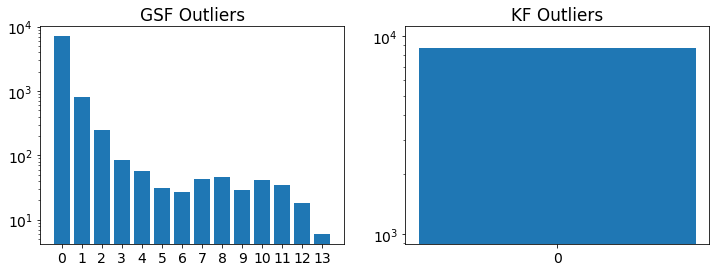

In [151]:
fig, axes = plt.subplots(1,2, figsize=(12,4))

for ax, df, fitter in zip(axes, [summary_gsf, summary_kf], ["GSF", "KF"]):
    ax.bar(*np.unique(df["nOutliers"], return_counts=True))
    ax.set_title(f"{fitter} Outliers")
    ax.set_yscale('log')
    _ = ax.set_xticks(np.unique(df["nOutliers"]))

In [130]:
"tracks with outliers : {:.2%}".format(sum(np.unique(summary_gsf["nOutliers"], return_counts=True)[1][1:]) / len(summary_gsf))

'tracks with outliers : 17.10%'

In [131]:
#summary_gsf = summary_gsf[ summary_gsf["res_eQOP_fit"].between(-30,30) ]
summary_gsf = summary_gsf[ summary_gsf["nOutliers"] == 0 ]

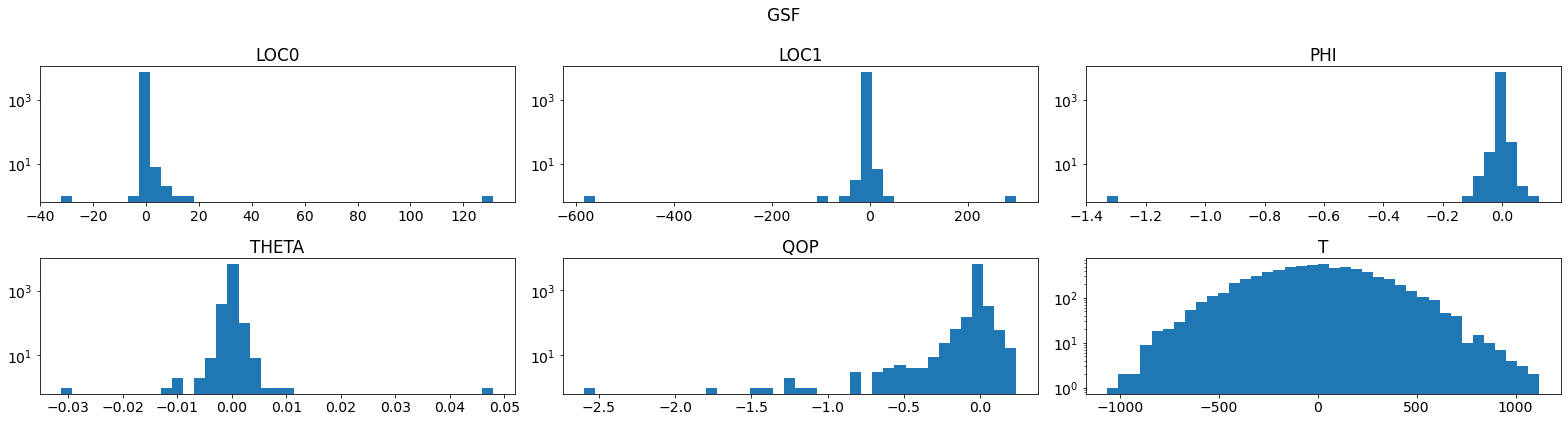

In [132]:
fig, axes = plt.subplots(2,3,figsize=(22,6))

for ax, key in zip(axes.flatten(), ['res_eLOC0_fit', 'res_eLOC1_fit', 'res_ePHI_fit', 'res_eTHETA_fit', 'res_eQOP_fit', 'res_eT_fit']):
    ax.hist(summary_gsf[key], bins='rice')
    ax.set_yscale('log')
    ax.set_title(key[5:][:-4])
    
fig.suptitle("GSF")
fig.tight_layout()

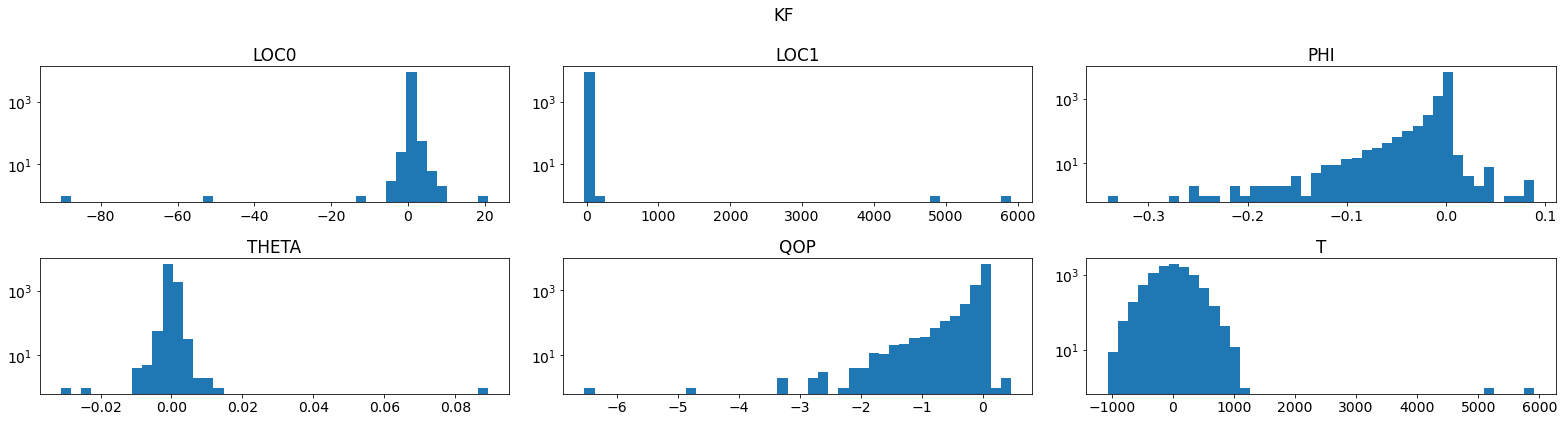

In [133]:
fig, axes = plt.subplots(2,3,figsize=(22,6))

for ax, key in zip(axes.flatten(), ['res_eLOC0_fit', 'res_eLOC1_fit', 'res_ePHI_fit', 'res_eTHETA_fit', 'res_eQOP_fit', 'res_eT_fit']):
    ax.hist(summary_kf[key], bins='rice')
    ax.set_yscale('log')
    ax.set_title(key[5:][:-4])
    
fig.suptitle("KF")
fig.tight_layout()

In [134]:
summary_gsf["res_eP_fit"] = summary_gsf["t_p"] - abs(1./summary_gsf["eQOP_fit"])
summary_kf["res_eP_fit"] = summary_kf["t_p"] - abs(1./summary_kf["eQOP_fit"])

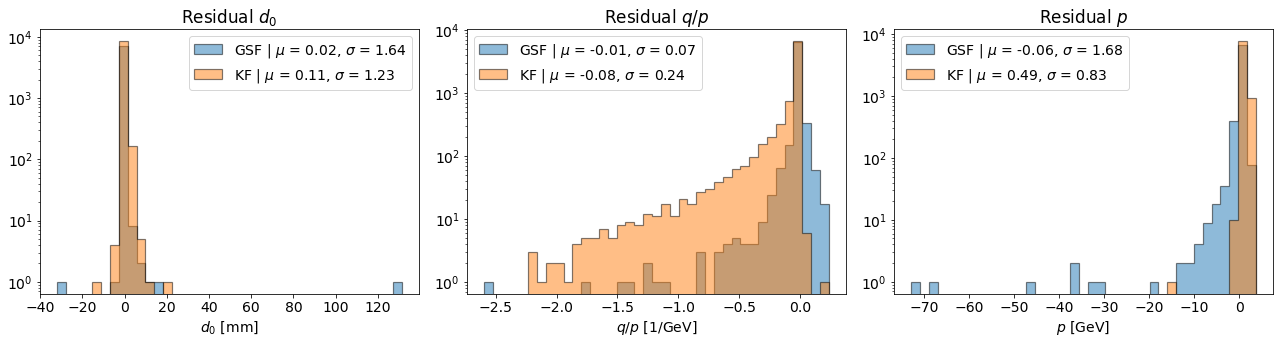

In [135]:
fig, axes = plt.subplots(1,3, figsize=(18,5))

for ax, key, coor, unit, legend_loc in zip(axes,
                                           ["res_eLOC0_fit", "res_eQOP_fit", "res_eP_fit"],
                                           ["$d_0$", "$q/p$", "$p$"],
                                           ["mm", "1/GeV", "GeV"],
                                           ["upper right", "upper left", "upper left"]):
    bins="rice"
    
    
    for df, fitter in zip([summary_gsf, summary_kf], ["GSF", "KF"]):
        fit = norm.fit(df[key]) 
            
        label = "{} | $\mu$ = {:.2f}, $\sigma$ = {:.2f}".format(fitter, *fit)
        _, bins, _ = ax.hist(df[key], bins=bins, label=label, alpha = 0.5, histtype='stepfilled', linewidth=1.2, edgecolor='black')
        ax.set_title("Residual {}".format(coor))
        ax.legend(loc=legend_loc)
        ax.set_yscale('log')
        ax.set_xlabel("{} [{}]".format(coor, unit))
        
fig.tight_layout()

## Core-Tail resolution

In [136]:
def analyse_core_tail(df, key, clip_range=None, core_share=0.95):
    hist, bins = np.histogram(np.clip(df[key],-3, 3), bins=300)
    argmax = np.argmax(hist)
    mode = 0.5 * (bins[argmax] + bins[argmax+1])
    
    print("mode", mode)
    print("mean", np.mean(df[key]))
    print("std", np.std(df[key]))
    print("rms", np.sqrt(np.mean(np.square(df[key]))))
    print("skewness", skew(df[key]))
          
    # Compute core range
    d = np.quantile(np.sort(abs(df[key])), core_share)     
    core_range = (-d, d)
    
    df["is_core"] = df[key].between(*core_range)
    
    core_percent = 100. * sum(df["is_core"]) / len(df)
    tail_percent = 100. - core_percent
    
    core_part = df[key][df["is_core"]]
    tail_part = df[key][np.logical_not(df["is_core"])]

    fit_core = norm.fit(core_part)
    fit_tail = norm.fit(tail_part)
    
    print("core range",min(core_part),max(core_part))
    print("tail range",min(tail_part),max(tail_part))
    
    if clip_range is None:
        clip_range = (
            min(min(core_part), min(tail_part)),
            max(max(core_part), max(tail_part))
        )
        
    assert clip_range[0] < 0.0
    assert clip_range[1] > 0.0
        
    fig, ax = plt.subplots(1,2,figsize=(17,5))
     
    tail_label = "tail ({:.1f}%) | $\mu$={:.2f}, $\sigma$={:.2f}".format(tail_percent, *fit_tail)
    core_label = "core ({:.1f}%) | $\mu$={:.2f}, $\sigma$={:.2f}".format(core_percent, *fit_core)
    hist_options = dict(edgecolor='black', linewidth=1.2, stacked=True, label=[tail_label, core_label])
        
    # Whole plot
    _, bins = np.histogram(np.clip(df[key], *clip_range), bins=50)
    ax[0].hist([np.clip(tail_part, *clip_range), np.clip(core_part, *clip_range)], bins=bins, **hist_options)
    ax[0].set_yscale('log')
    ax[0].legend()
    ax[0].set_title("Whole range")
    
    # Zoom plot
    zoom = lambda x: x[ np.logical_and(x > 3*core_range[0], x < 3*core_range[1]) ]
    
    _, bins = np.histogram(zoom(df[key]), bins=50)
    ax[1].hist([zoom(tail_part), core_part], bins=bins, **hist_options)
    ax[1].set_yscale('log')
    ax[1].legend()
    ax[1].set_title("Zoom range")
        
    return fig, ax

### QOP

mode -0.0038284738548099995
mean -0.0059233634
std 0.06937199831008911
rms 0.06962446
skewness -16.653959496578334
core range -0.0628499984741211 0.06276826560497284
tail range -2.596625566482544 0.2370324581861496


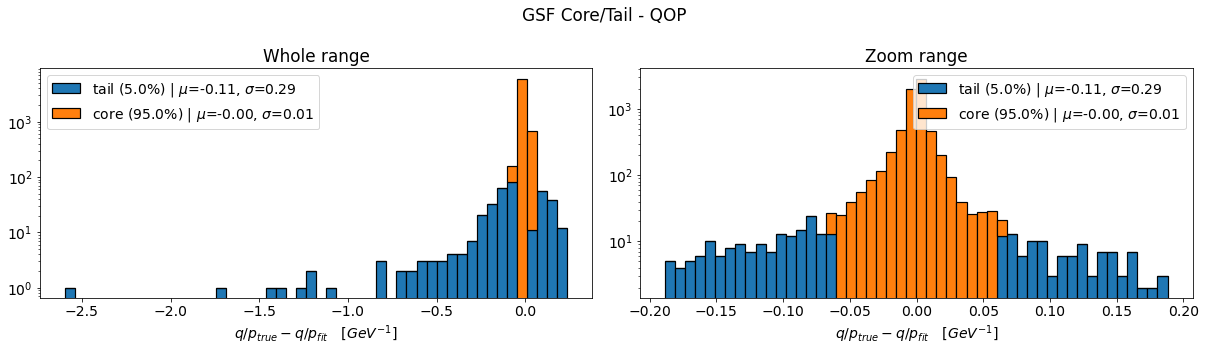

In [137]:
fig, axes = analyse_core_tail(summary_gsf, "res_eQOP_fit")
for ax in axes:
    ax.set_xlabel("$q/p_{true} - q/p_{fit} \quad [GeV^{-1}]$")
fig.suptitle("GSF Core/Tail - QOP")
fig.tight_layout()

mode -0.00347662391141057
mean -0.078450926
std 0.23646420240402222
rms 0.24913822
skewness -7.795448730702204
core range -0.4116799235343933 0.19791379570960999
tail range -6.533694267272949 0.4641888737678528


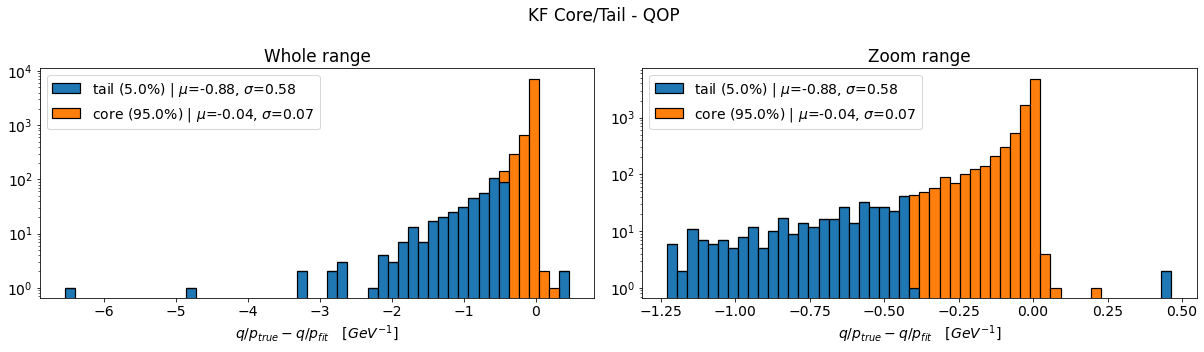

In [138]:
fig, axes = analyse_core_tail(summary_kf, "res_eQOP_fit")
for ax in axes:
    ax.set_xlabel("$q/p_{true} - q/p_{fit} \quad [GeV^{-1}]$")
fig.suptitle("KF Core/Tail - QOP")
fig.tight_layout()

### LOC0

mode -0.009999999776482582
mean 0.022432907
std 1.6356698274612427
rms 1.6358445
skewness 71.74843772933266
core range -0.11827129125595093 0.11789809912443161
tail range -32.015350341796875 131.37802124023438


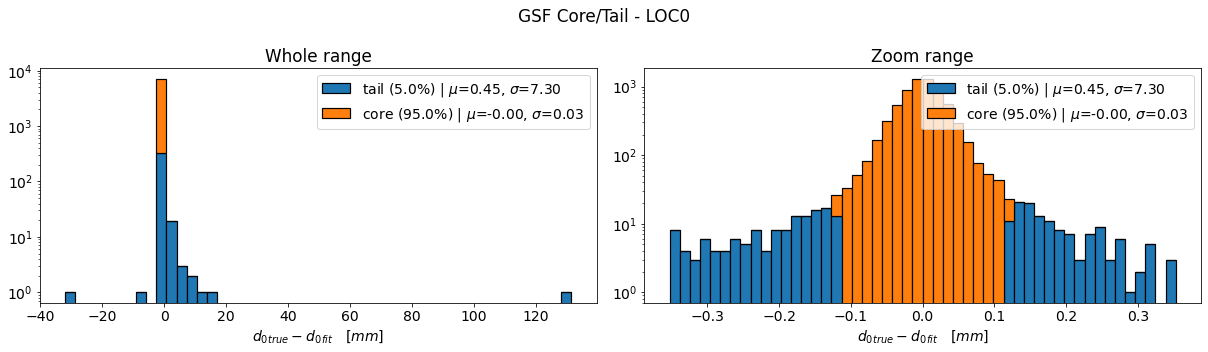

In [139]:
fig, axes = analyse_core_tail(summary_gsf, "res_eLOC0_fit")
for ax in axes:
    ax.set_xlabel("${d_0}_{true} - {d_0}_{fit} \quad [mm]$")
fig.suptitle("GSF Core/Tail - LOC0")
fig.tight_layout()

mode 0.009999999776482582
mean 0.11370926
std 1.2295587062835693
rms 1.2348062
skewness -53.86058437331954
core range -0.7029663920402527 0.7717464566230774
tail range -90.34346008300781 20.770780563354492


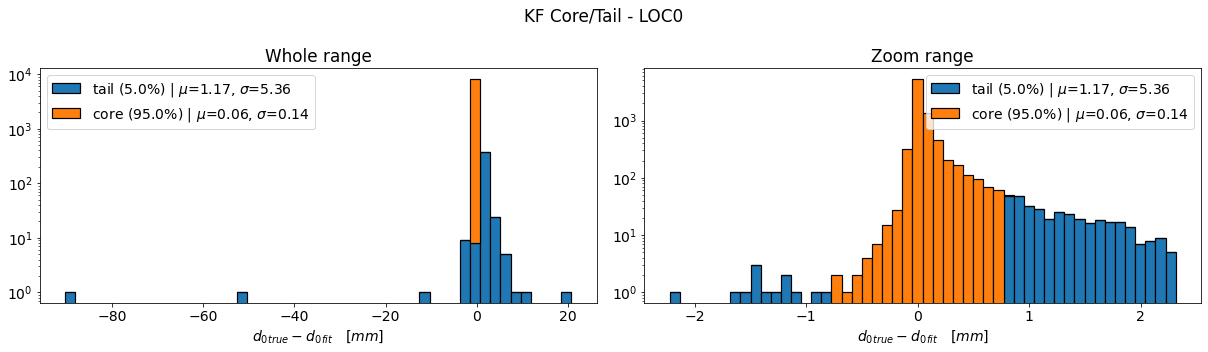

In [140]:
fig, axes = analyse_core_tail(summary_kf, "res_eLOC0_fit", (-100,100))
for ax in axes:
    ax.set_xlabel("${d_0}_{true} - {d_0}_{fit} \quad [mm]$")
fig.suptitle("KF Core/Tail - LOC0")
fig.tight_layout()